# Feature selection on UCI red-wine dataset

In [184]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from tqdm import tqdm_notebook

## Load and channel-wise normalize data

In [23]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data_with_labels = np.array(pd.read_csv(url, sep=";"))

np.random.shuffle(data_with_labels)

data = data_with_labels[:,:11]
labels = data_with_labels[:,11]

data[:,:11] -= data[:,:11].mean()
data[:,:11] /= data[:,:11].std()

data.shape

data_5_6 = data[np.logical_or(labels == 5, labels == 6)]
labels_5_6 = labels[np.logical_or(labels == 5, labels == 6)]

labels_5_6[labels_5_6 == 5] = 0
labels_5_6[labels_5_6 == 6] = 1

data_5_6_train, data_5_6_valid = data_5_6[:int(len(data_5_6) * 0.5)], data_5_6[-int(len(data_5_6) * 0.5):]
labels_5_6_train, labels_5_6_valid = labels_5_6[:int(len(data_5_6) * 0.5)], labels_5_6[-int(len(data_5_6) * 0.5):]

In [22]:
q5 = data[labels == 5]
q6 = data[labels == 6]

## Fisher criterion

In [34]:
def get_fisher_projections(data_1, data_2, return_w=False):
    
    m1 = np.mean(data_1, axis=0)
    m2 = np.mean(data_2, axis=0)
    
    Sw = (data_1 - m1).T @ (data_1 - m1) + (data_2 - m2).T @ (data_2 - m2)
    
    w = np.linalg.inv(Sw) @ (m2 - m1).reshape(-1, 1)
    w /= np.linalg.norm(w)
    
    if not return_w:
        return data_1 @ w, data_2 @ w
    else:
        return data_1 @ w, data_2 @ w, w

In [35]:
proj5, proj6 = get_fisher_projections(q5, q6)

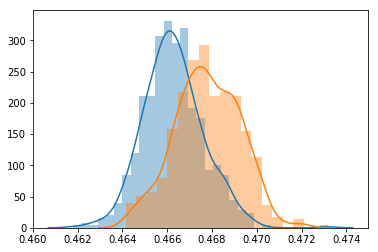

In [36]:
sns.distplot(proj5)
sns.distplot(proj6)
plt.show()

In [37]:
def fisher_criterion(projs_1, projs_2):
    return float((projs_1.mean() - projs_2.mean()) ** 2 / (projs_1.var() + projs_2.var()))

In [38]:
fisher_criterion(proj5, proj6)

0.5856450741103125

In [39]:
def score_combination(retained_ids):
    retained_ids = [i - 1 for i in retained_ids]
    proj_1, proj_2 = get_fisher_projections(q5[:, retained_ids], q6[:, retained_ids])
    return fisher_criterion(proj_1, proj_2)

## Node class

In [40]:
class Node:
    
    def __init__(self, id, depth, parents):
        self.id = id
        self.expanded = False
        self.searched = False
        self.depth = depth
        self.parents = parents

## Branch-and-bound class

In [41]:
class BranchAndBound:
    
    def __init__(self, num_features, num_features_retained, scoring_func, verbose):
        
        self.feature_ids = np.arange(1, num_features + 1)
        self.max_id = num_features
        self.num_features_retained = num_features_retained
        num_features_removed = num_features - num_features_retained
        self.max_depth = num_features_removed
        
        self.scoring_func = scoring_func
        self.verbose = verbose
        
        self.construct_graph()
    
    def has_valid_and_unexpanded_nodes(self, graph):
        """Helper method to self.construct_graph."""
        for n in graph.nodes:
            if not n.expanded and n.depth < self.max_depth:
                return True
        return False
    
    def get_valid_and_unexpanded_nodes(self, graph):
        """Helper method to self.construct_graph."""
        unexpanded_nodes = []
        for n in graph.nodes:
            if not n.expanded and n.depth < self.max_depth:
                unexpanded_nodes.append(n)
        return unexpanded_nodes
    
    def expand(self, parent):
        """Helper method to self.construct_graph."""
    
        children = []
        edges_to_children = []

        for id in self.feature_ids:

            # suppose the next step is already taken

            steps_remaining = self.max_depth - (parent.depth + 1)
            steps_allowed = self.max_id - id

            # id > parent.id so that branches are not duplicates of each other
            # steps_allowed >= steps_remaining because the depth of the tree along each branch is fixed

            if id > parent.id and steps_allowed >= steps_remaining:

                child = Node(
                    id=id, 
                    depth=parent.depth + 1,
                    parents=parent.parents + [parent]
                )

                children.append(child)
                edges_to_children.append((parent, child))

        parent.expanded = True

        return children, edges_to_children
        
    def construct_graph(self):
        """Called in self.__init__."""
    
        # ==============================
        # create a directional graph in order to use the method self.G.successors
        # ==============================
        
        self.G = nx.DiGraph()

        # ==============================
        # create a root node
        # note that the root node does not represent any feature, so it has an id of 0
        # ==============================
        
        self.root_node = Node(id=0, depth=0, parents=[])
        
        # ==============================
        # create first-level (depth=1) nodes that are directly connected to the root node
        # ==============================
        
        # In order to decide the number of first-level nodes,
        # we need to make sure that the first-level nodes have a
        # highest feature id <= self.max_id - self.num_features_removed = self.num_features_retained.
        
        # Since we are indexing an array, we need to plus 1 to self.num_features_retained
        # in order to obtain the first self.num_features_retained feature ids.
        
        first_level_ids = self.feature_ids[:self.num_features_retained+1]
        
        for id in list(first_level_ids):
            
            new_node = Node(id=id, depth=1, parents=[self.root_node])
            self.G.add_node(new_node)
                       
        self.G.add_edges_from([(self.root_node, n) for n in self.G.nodes if n != self.root_node])
        
        # ==============================
        # apparently, the root node has been expanded because all first-level nodes are added to the graph
        # ==============================
        
        self.root_node.expanded = True
        
        # ==============================
        # construct the remaining part of the graph
        # ==============================
        
        while self.has_valid_and_unexpanded_nodes(self.G):
            for n in self.get_valid_and_unexpanded_nodes(self.G):
                children, edges_to_children = self.expand(n)
                self.G.add_nodes_from(children)
                self.G.add_edges_from(edges_to_children)
        
    def traverse(self, node):
        """Called in self.find_best_ids."""
        
        set_of_all_ids = set(list(self.feature_ids))

        for n in self.G.successors(node):

            comb_of_ids = {n.id for n in n.parents + [n]}
            score = self.scoring_func(set_of_all_ids - comb_of_ids)
            
            # If score <= self.benchmark, no additional removals of features are evaluated because
            # the self.scoring_func satisfies the monotonicity property.

            if score > self.benchmark:
                if n.depth == self.max_depth:
                    self.benchmark = score
                    self.arg_benchmark = list(set_of_all_ids - comb_of_ids)
                else:
                    self.traverse(n)
            else:  
                pass
                
    def find_best_ids(self):

        set_of_all_ids = set(list(self.feature_ids))

        # ==============================
        # Travel all the way through the tree once along a random path ...
        # ==============================
        
        current_node = self.root_node
        nodes_on_path = [self.root_node]
        while current_node.depth < self.max_depth:  # stop when current_node.depth == max_depth
            current_node = np.random.choice(list(self.G.successors(current_node)))
            nodes_on_path.append(current_node)
            
        # ==============================
        # ... so that a pair of benchmark and arg_benchmark can be obtained.
        # ==============================
    
        comb_of_ids = {n.id for n in nodes_on_path}
        
        self.benchmark = self.scoring_func(set_of_all_ids - comb_of_ids)
        self.arg_benchmark = set_of_all_ids - comb_of_ids
        
        # ==============================
        # Recursively traverse following the assumption that self.scoring_func (J) satisties a monotonicity property such that
        # $J(X^+) \geq J(X)$ where $X^+$ denotes a set of features and X $\subset$ X^+$.
        #
        # For more details on how this is implemented, see self.traversal.
        #
        # The current best and its performance are kept in variables self.benchmark and self.arg_benchmark respectively.
        # ==============================

        self.traverse(self.root_node)

        # ==============================
        # Print out the overall best and its performance if required.
        # ==============================
        
        if self.verbose:
            print('Best Fisher criterion:', round(self.benchmark, 3))
            print('Features to retain:', self.arg_benchmark)
            
        # ==============================
        # The overall best, self.arg_benchmark, is converted into array indexing for Numpy advanced indexing along the feature axis.
        # ==============================
        
        return [i - 1 for i in self.arg_benchmark]

## Analysis

### Simple selection criterion does not model the true relationship between the number of features selected and the model's performance.

In [242]:
num_features_retained_s = np.arange(1, 11+1)
fisher_criterions = []

train_accs_mlp = []
valid_accs_mlp = []

train_accs_logreg = []
valid_accs_logreg = []

for i in tqdm_notebook(num_features_retained_s, leave=False):
    
    bab = BranchAndBound(
        num_features=11, 
        num_features_retained=i, 
        scoring_func=score_combination,
        verbose=False
    )
    arg_benchmark = bab.find_best_ids()
    
    best_proj_5, best_proj_6, w = get_fisher_projections(q5[:, arg_benchmark], q6[:, arg_benchmark], return_w=True)
    
    fisher_criterions.append(fisher_criterion(best_proj_5, best_proj_6))
    
    # ==============================
    # MLP
    # ==============================
    
    valid_temps = []
    train_temps = []
    
    for i in range(5):  # since MLP is less consistent, we average stats over multiple runs
        
        mlp_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(300, 300, 300), max_iter=int(1e7)).fit(
            data_5_6_train[:, arg_benchmark], labels_5_6_train
        )

        valid_temps.append(mlp_clf.score(data_5_6_valid[:, arg_benchmark], labels_5_6_valid))
        train_temps.append(mlp_clf.score(data_5_6_train[:, arg_benchmark], labels_5_6_train))
        
    train_accs_mlp.append(np.mean(train_temps))
    valid_accs_mlp.append(np.mean(valid_temps))
    
    # ==============================
    # Logistic regression
    # ==============================
    
    logreg_clf = LogisticRegression(solver='lfgbs', multi_class='ovr').fit(data_5_6_train[:, arg_benchmark], labels_5_6_train)
    
    train_accs_logreg.append(logreg_clf.score(data_5_6_train[:, arg_benchmark], labels_5_6_train))
    valid_accs_logreg.append(logreg_clf.score(data_5_6_valid[:, arg_benchmark], labels_5_6_valid))

/Users/yangzhihan/anaconda/envs/deeplearning_googlecloud/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

In [ ]:
with open('training_history.json', 'w+') as json_f:
    json.dump([
        train_accs_mlp,
        valid_accs_mlp,
        train_accs_logreg,
        valid_accs_logreg
    ], json_f)

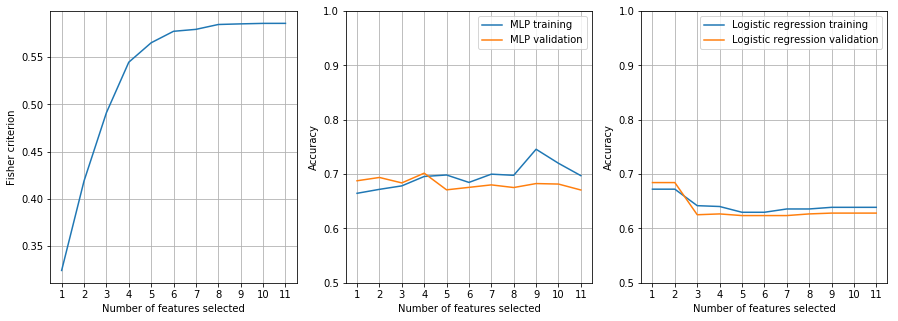

In [54]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(num_features_retained_s, fisher_criterions)
plt.xticks(num_features_retained_s)
plt.xlabel('Number of features selected'); plt.ylabel('Fisher criterion')
plt.grid()

fig.add_subplot(132)

plt.plot(num_features_retained_s, train_accs_mlp, label='MLP training')
plt.plot(num_features_retained_s, valid_accs_mlp, label='MLP validation')
plt.xticks(num_features_retained_s)
plt.ylim(0.5, 1)
plt.xlabel('Number of features selected'); plt.ylabel('Accuracy')
plt.legend()
plt.grid()

fig.add_subplot(133)

plt.plot(num_features_retained_s, train_accs_logreg, label='Logistic regression training')
plt.plot(num_features_retained_s, valid_accs_logreg, label='Logistic regression validation')
plt.xticks(num_features_retained_s)
plt.ylim(0.5, 1)
plt.xlabel('Number of features selected'); plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

From the plots above, it is clear that, while increasing the number of features always improve upon Fisher criterion (regardless of order), doing so does not necessarily significantly improve the validation accuracy of MLP or Logistic regression. In fact, the validation accuracy dropped significantly as soon as more than 2 features were selected. This is likely due to **the curse of dimensionality**. On the other hand, MLP seems to be more robust against this issue.

### Feature selection for logistic regression

Simple selection criterion offers a useful way to compare sets of variables having the same number of elements.

In [243]:
bab = BranchAndBound(
        num_features=11, 
        num_features_retained=3,
        scoring_func=score_combination,
        verbose=False
    )
best_3_ids = bab.find_best_ids()

In [244]:
best_3_ids

[1, 10, 6]

In [245]:
 logreg_clf = LogisticRegression(solver='liblinear', multi_class='ovr').fit(data_5_6_train[:, best_3_ids], labels_5_6_train)

In [246]:
fisher_acc = logreg_clf.score(data_5_6_valid[:, best_3_ids], labels_5_6_valid)

In [247]:
random_accs = []
for i in range(1000):
    random_3_ids = np.random.choice(np.arange(0, 11), size=3)
    logreg_clf = LogisticRegression(solver='liblinear', multi_class='ovr').fit(data_5_6_train[:, random_3_ids], labels_5_6_train)
    acc = logreg_clf.score(data_5_6_valid[:, random_3_ids], labels_5_6_valid)
    random_accs.append(acc)

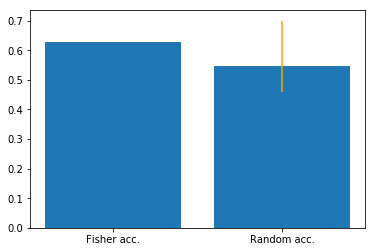

In [248]:
plt.bar(['Fisher acc.', 'Random acc.'], [fisher_acc, np.mean(random_accs)])
plt.errorbar(
    ['Random acc.'], 
    np.mean(random_accs), 
    np.array([[np.mean(random_accs) - np.quantile(random_accs, 0.025)], [np.quantile(random_accs, 0.975) - np.mean(random_accs)]]),
    color='orange'
)
plt.show()

Although the best 3 features selected using Fisher criterion performs better than a random set of 3 features on average, the later out-performs the prior occasionally.